In [1]:
import pandas as pd

import oversampling_binary
from oversampling_binary import split_dataset, apply_smote
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# CLASSIFICAZIONE BINARIA

Carica e prepara i dati

In [2]:
X_train_imputed, X_val_imputed, X_test_imputed, y_train_encoded_filtered, y_val_encoded, y_test_encoded, subclasses_train, class_encoder = split_dataset('audio_features.csv')

Distribuzione delle classi nel set di addestramento:
Class
Target        34635
Non-Target     5791
Name: count, dtype: int64
Distribuzione delle subclassi nel set di addestramento:
Subclass
Tanker                      9181
Passengership               8847
Tug                         8539
Cargo                       7705
Sperm Whale                 1087
                            ... 
Ringed Seal                    2
Short-finned Pilot Whale       2
Black Drum                     2
Pygmy Right Whale              1
True_s beaked whale            1
Name: count, Length: 107, dtype: int64
Dimensioni del set di addestramento: (40426, 15) (40426,)
Dimensioni del set di validazione: (4333, 15) (4333,)
Dimensioni del set di test: (6234, 15) (6234,)


## SMOTE

In [3]:
X_train_resampled, y_train_resampled = apply_smote(X_train_imputed, y_train_encoded_filtered, subclasses_train)

SMOTE tra le subclass di Target:
Distribuzione subclassi di Target dopo SMOTE:
Subclass
Acoustic Harassment Devices         9181
Acoustic release                    9181
Cargo                               9181
Echosounder                         9181
Explosion                           9181
Fishing pinger                      9181
Passengership                       9181
Scuba divers                        9181
Seafloor fossil fuel processing     9181
Seal bomb                           9181
Seismic airguns surveys             9181
Sonar                               9181
Tanker                              9181
Tug                                 9181
Underwater Communication Signals    9181
Vessel                              9181
Name: count, dtype: int64
SMOTE tra le subclass di Non-Target:
Distribuzione subclassi di Non-Target dopo SMOTE:
Subclass
Ambient Noise         1087
Manatee               1087
Right whale           1087
Red grouper           1087
Rain                  1087

In [4]:
# Imposta pandas per visualizzare tutto il contenuto
pd.set_option('display.max_rows', None)  # Rimuove la limitazione del numero massimo di righe visualizzate
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne

In [5]:
# Converti i dati in DataFrame
X_train_df = pd.DataFrame(X_train_resampled)
X_val_df = pd.DataFrame(X_val_imputed)
X_test_df = pd.DataFrame(X_test_imputed)

In [6]:
# Aggiungi le etichette per il target
X_train_df['Class'] = y_train_resampled
X_val_df['Class'] = y_val_encoded
X_test_df['Class'] = y_test_encoded

## Distribuzione delle classi nel set di addestramento dopo SMOTE

In [7]:
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Class'])
print("Distribuzione delle classi nel set di training dopo SMOTE:")
display(y_train_resampled_df['Class'].value_counts())

Distribuzione delle classi nel set di training dopo SMOTE:


Class
1.0    146896
0.0    146896
Name: count, dtype: int64

# ESPERIMENTO 1

Esperimento effettuato prendendo come riferimento alcune features numeriche da "Malfante et al."

## ADDESTRAMENTO RANDOM FOREST

In [8]:
# Converte i DataFrame in ndarray
X_train_resampled_array = X_train_resampled  # Supponendo che sia già un ndarray
X_val_imputed_array = X_val_imputed.values  # Converti il DataFrame in ndarray
X_test_imputed_array = X_test_imputed.values  # Converti il DataFrame in ndarray

In [9]:
# Addestra il modello Random Forest
random_forest_model = oversampling_binary.train_random_forest(
    X_train_resampled_array,
    y_train_resampled,
    X_val_imputed_array,
    y_val_encoded,
    X_test_imputed_array,
    y_test_encoded
)

Inizio dell'addestramento del modello Random Forest...


Addestramento Random Forest: 100%|██████████| 100/100 [01:49<00:00,  1.09s/albero]

Performance sul set di validazione:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       906
           1       1.00      0.99      0.99      3427

    accuracy                           0.99      4333
   macro avg       0.99      0.99      0.99      4333
weighted avg       0.99      0.99      0.99      4333

Accuratezza sul set di validazione: 0.9914608816062774
Performance sul set di test:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1115
           1       0.92      0.99      0.96      5119

    accuracy                           0.92      6234
   macro avg       0.94      0.79      0.84      6234
weighted avg       0.93      0.92      0.92      6234

Accuratezza sul set di test: 0.92316329804299


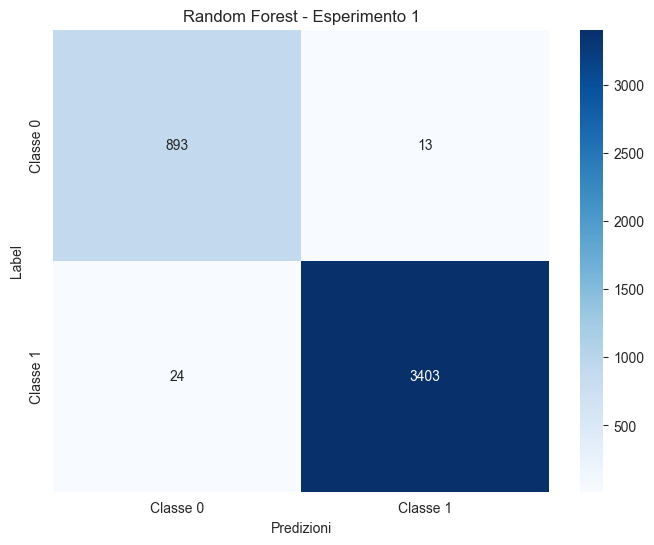

In [10]:
# 1. Effettua le predizioni sul set di convalida
y_pred = random_forest_model.predict(X_val_imputed_array)

# 2. Calcola la matrice di confusione
cm = confusion_matrix(y_val_encoded, y_pred)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('Random Forest - Esperimento 1')
plt.show()

# ADDESTRAMENTO SVM

In [11]:
import oversampling_binary

In [12]:
svm_model = oversampling_binary.train_svm(X_train_resampled_array, y_train_resampled, X_val_imputed_array, y_val_encoded, X_test_imputed_array, y_test_encoded)

Inizio addestramento del modello...
Tempo di addestramento: 1.294888973236084
Inizio previsione sul set di validazione...
Tempo di previsione sul set di validazione: 0.004313945770263672
Performance del set di validazione:
Accuracy: 0.8786060466189707
              precision    recall  f1-score   support

  Non-Target     0.6605    0.8631    0.7483       906
      Target     0.9606    0.8827    0.9200      3427

    accuracy                         0.8786      4333
   macro avg     0.8105    0.8729    0.8342      4333
weighted avg     0.8979    0.8786    0.8841      4333

Inizio previsione sul set di test...
Tempo di previsione sul set di test: 0.0009999275207519531
Performance del set di test:
Accuracy: 0.8928456849534809
              precision    recall  f1-score   support

  Non-Target     0.7326    0.6314    0.6782      1115
      Target     0.9221    0.9498    0.9357      5119

    accuracy                         0.8928      6234
   macro avg     0.8273    0.7906    0.8070      

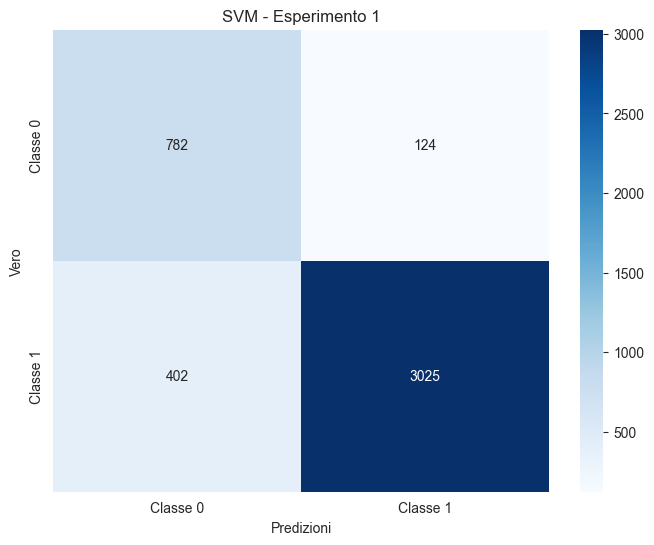

In [13]:
# 1. Effettua le predizioni sul set di convalida
y_pred_svm = svm_model.predict(X_val_imputed_array)

# 2. Calcola la matrice di confusione
cm_svm = confusion_matrix(y_val_encoded, y_pred_svm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Vero')
plt.title('SVM - Esperimento 1')
plt.show()

# ADDESTRAMENTO LIGHT GBM

In [14]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adatta questo valore al numero di core che desideri utilizzare

In [15]:
y_train_resampled = y_train_resampled.astype(int)
y_val_encoded = y_val_encoded.astype(int)
y_test_encoded = y_test_encoded.astype(int)


In [16]:
lightgbm_model = oversampling_binary.train_lightgbm(X_train_resampled_array, y_train_resampled, X_val_imputed_array, y_val_encoded, X_test_imputed_array, y_test_encoded, 10)

Training Progress:  30%|███       | 3/10 [00:00<00:00, 17.16it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 29379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 29379, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

Training Progress:  50%|█████     | 5/10 [00:00<00:00, 11.22it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 117516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 117516, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

Training Progress:  70%|███████   | 7/10 [00:01<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 88136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 235032, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625004 -> initscore=0.510844
[LightGBM] [Info] Start training from score 0.510844


Training Progress:  80%|████████  | 8/10 [00:03<00:01,  1.55it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 117515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 264411, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555559 -> initscore=0.223159
[LightGBM] [Info] Start training from score 0.223159


Training Progress:  90%|█████████ | 9/10 [00:04<00:00,  1.17it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 146894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 293790, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000014
[LightGBM] [Info] Start training from score 0.000014


Training Progress: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Distribuzione delle classi reali (validazione): [ 906 3427]
Distribuzione delle classi predette (validazione): [ 923 3410]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       906
           1       1.00      0.99      0.99      3427

    accuracy                           0.99      4333
   macro avg       0.98      0.99      0.98      4333
weighted avg       0.99      0.99      0.99      4333

Accuratezza sul set di validazione: 0.9892
Distribuzione delle classi reali (test): [1115 5119]
Distribuzione delle classi predette (test): [1099 5135]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1115
           1       0.99      0.99      0.99      5119

    accuracy                           0.99      6234
   macro avg       0.98      0.98      0.98      6234
weighted avg       0.99      0.99

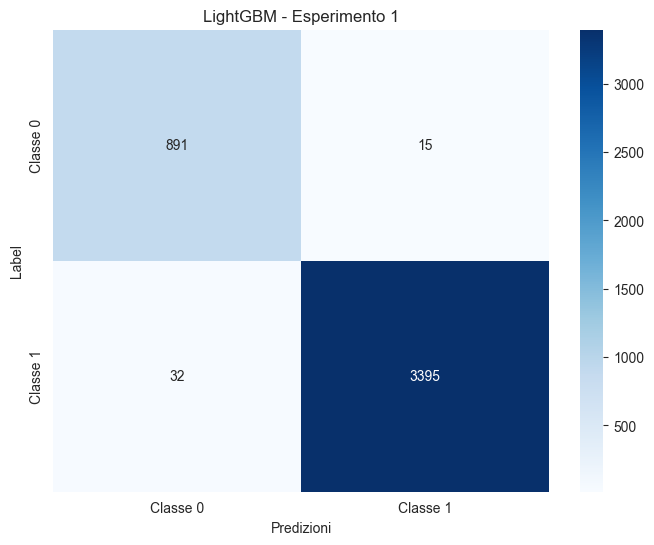

In [17]:
# 1. Effettua le predizioni sul set di convalida
y_pred_lightgbm = lightgbm_model.predict(X_val_imputed_array)

# Se il modello restituisce probabilità, ottieni le etichette predette
y_pred_lightgbm = (y_pred_lightgbm > 0.5).astype(int)  # Usa la soglia di 0.5 per classificazione binaria

# 2. Calcola la matrice di confusione
cm_lightgbm = confusion_matrix(y_val_encoded, y_pred_lightgbm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lightgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('LightGBM - Esperimento 1')
plt.show()

# Esperimento 2

Esperimento effettuato prendendo come riferimento alcune features numeriche da "BirdNet"

In [18]:
#SPLIT
X_train_imputed_exp1, X_val_imputed_exp1, X_test_imputed_exp1, y_train_encoded_filtered_exp1, y_val_encoded_exp1, y_test_encoded_exp1, subclasses_train, class_encoder_exp1 = split_dataset(
    'exp1_audio_features.csv')

Distribuzione delle classi nel set di addestramento:
Class
Target        34635
Non-Target     5791
Name: count, dtype: int64
Distribuzione delle subclassi nel set di addestramento:
Subclass
Tanker                                     9181
Passengership                              8847
Tug                                        8539
Cargo                                      7705
Sperm Whale                                1087
Humpback Whale                             1063
Fin, Finback Whale                          496
Vessel                                      282
Pygmy Blue Whale                            243
Soundscape                                  185
Fraser_s Dolphin                            171
Long-Finned Pilot Whale                     159
Rain                                        121
Spinner Dolphin                             119
Grampus, Risso_s Dolphin                    116
Killer Whale                                114
Short-Finned (Pacific) Pilot Whale        

In [19]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adatta questo valore al numero di core che desideri utilizzare

In [20]:
#SMOTE
X_train_resampled_exp1, y_train_resampled_exp1 = apply_smote(X_train_imputed_exp1, y_train_encoded_filtered_exp1, subclasses_train)

SMOTE tra le subclass di Target:
Distribuzione subclassi di Target dopo SMOTE:
Subclass
Acoustic Harassment Devices         9181
Acoustic release                    9181
Cargo                               9181
Echosounder                         9181
Explosion                           9181
Fishing pinger                      9181
Passengership                       9181
Scuba divers                        9181
Seafloor fossil fuel processing     9181
Seal bomb                           9181
Seismic airguns surveys             9181
Sonar                               9181
Tanker                              9181
Tug                                 9181
Underwater Communication Signals    9181
Vessel                              9181
Name: count, dtype: int64
SMOTE tra le subclass di Non-Target:
Distribuzione subclassi di Non-Target dopo SMOTE:
Subclass
Ambient Noise                              1087
Manatee                                    1087
Right whale                           

In [21]:
y_train_resampled_df_exp1 = pd.DataFrame(y_train_resampled_exp1, columns=['Class'])
print("Distribuzione delle classi nel set di training dopo SMOTE:")
display(y_train_resampled_df_exp1['Class'].value_counts())

Distribuzione delle classi nel set di training dopo SMOTE:


Class
1.0    146896
0.0    146896
Name: count, dtype: int64

In [22]:
# Converte i DataFrame in ndarray
X_train_resampled_array_exp1 = X_train_resampled_exp1  # Supponendo che sia già un ndarray
X_val_imputed_array_exp1 = X_val_imputed_exp1.values  # Converti il DataFrame in ndarray
X_test_imputed_array_exp1 = X_test_imputed_exp1.values  # Converti il DataFrame in ndarray

In [23]:
#TRAIN
random_forest_model_exp1 = oversampling_binary.train_random_forest(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_array_exp1, y_val_encoded_exp1, X_test_imputed_array_exp1, y_test_encoded_exp1)

Inizio dell'addestramento del modello Random Forest...


Addestramento Random Forest: 100%|██████████| 100/100 [03:01<00:00,  1.81s/albero]

Performance sul set di validazione:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       906
           1       1.00      0.99      0.99      3427

    accuracy                           0.99      4333
   macro avg       0.98      0.99      0.99      4333
weighted avg       0.99      0.99      0.99      4333

Accuratezza sul set di validazione: 0.9903069466882067
Performance sul set di test:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1115
           1       0.98      0.99      0.99      5119

    accuracy                           0.98      6234
   macro avg       0.98      0.96      0.97      6234
weighted avg       0.98      0.98      0.98      6234

Accuratezza sul set di test: 0.9807507218479307


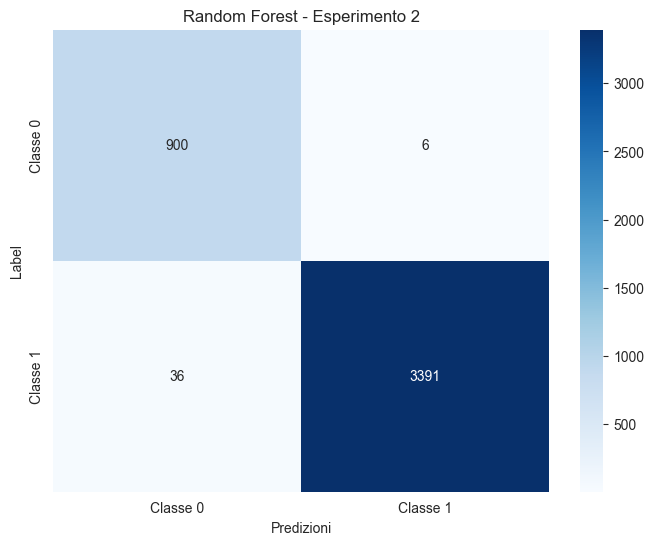

In [24]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp1 = random_forest_model_exp1.predict(X_val_imputed_array_exp1)

# 2. Calcola la matrice di confusione
cm_exp1 = confusion_matrix(y_val_encoded_exp1, y_pred_exp1)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp1, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('Random Forest - Esperimento 2')
plt.show()

In [25]:
svm_model_exp1 = oversampling_binary.train_svm(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_array_exp1, y_val_encoded_exp1, X_test_imputed_array_exp1, y_test_encoded_exp1)

Inizio addestramento del modello...
Tempo di addestramento: 1.4678688049316406
Inizio previsione sul set di validazione...
Tempo di previsione sul set di validazione: 0.003999471664428711
Performance del set di validazione:
Accuracy: 0.8975305792753289
              precision    recall  f1-score   support

  Non-Target     0.7584    0.7483    0.7533       906
      Target     0.9337    0.9370    0.9353      3427

    accuracy                         0.8975      4333
   macro avg     0.8460    0.8427    0.8443      4333
weighted avg     0.8970    0.8975    0.8973      4333

Inizio previsione sul set di test...
Tempo di previsione sul set di test: 0.0021736621856689453
Performance del set di test:
Accuracy: 0.8681424446583254
              precision    recall  f1-score   support

  Non-Target     0.6674    0.5238    0.5869      1115
      Target     0.9009    0.9432    0.9215      5119

    accuracy                         0.8681      6234
   macro avg     0.7842    0.7335    0.7542     

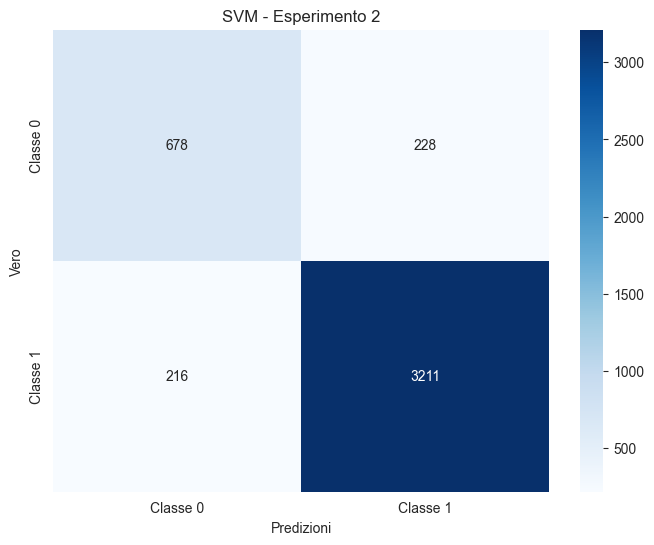

In [26]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp1_svm = svm_model_exp1.predict(X_val_imputed_array_exp1)

# 2. Calcola la matrice di confusione
cm_exp1_svm = confusion_matrix(y_val_encoded_exp1, y_pred_exp1_svm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp1_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Vero')
plt.title('SVM - Esperimento 2')
plt.show()

In [27]:
y_train_resampled_exp1 = y_train_resampled_exp1.astype(int)
y_val_encoded_exp1 = y_val_encoded_exp1.astype(int)
y_test_encoded_exp1 = y_test_encoded_exp1.astype(int)

In [28]:
lightgbm_model_exp1 = oversampling_binary.train_lightgbm(
    X_train_resampled_array_exp1,
    y_train_resampled_exp1,
    X_val_imputed_array_exp1,
    y_val_encoded_exp1,
    X_test_imputed_array_exp1,  
    y_test_encoded_exp1
)

Training Progress:  20%|██        | 2/10 [00:00<00:00, 11.44it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 29379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29379, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

Training Progress:  40%|████      | 4/10 [00:00<00:00,  6.84it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 117516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 117516, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

Training Progress:  50%|█████     | 5/10 [00:00<00:00,  5.23it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 146895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 146895, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

Training Progress:  60%|██████    | 6/10 [00:01<00:01,  2.14it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 58757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 205653, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714291 -> initscore=0.916315
[LightGBM] [Info] Start training from score 0.916315


Training Progress:  70%|███████   | 7/10 [00:03<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 88136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 235032, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625004 -> initscore=0.510844
[LightGBM] [Info] Start training from score 0.510844


Training Progress:  80%|████████  | 8/10 [00:04<00:01,  1.10it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 117515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 264411, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555559 -> initscore=0.223159
[LightGBM] [Info] Start training from score 0.223159


Training Progress:  90%|█████████ | 9/10 [00:06<00:01,  1.09s/it]

[LightGBM] [Info] Number of positive: 146896, number of negative: 146894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 293790, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000014
[LightGBM] [Info] Start training from score 0.000014


Training Progress: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

Distribuzione delle classi reali (validazione): [ 906 3427]
Distribuzione delle classi predette (validazione): [ 899 3434]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       906
           1       0.99      0.99      0.99      3427

    accuracy                           0.98      4333
   macro avg       0.98      0.97      0.98      4333
weighted avg       0.98      0.98      0.98      4333

Accuratezza sul set di validazione: 0.9836
Distribuzione delle classi reali (test): [1115 5119]
Distribuzione delle classi predette (test): [1070 5164]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1115
           1       0.99      1.00      0.99      5119

    accuracy                           0.99      6234
   macro avg       0.98      0.97      0.97      6234
weighted avg       0.99      0.99

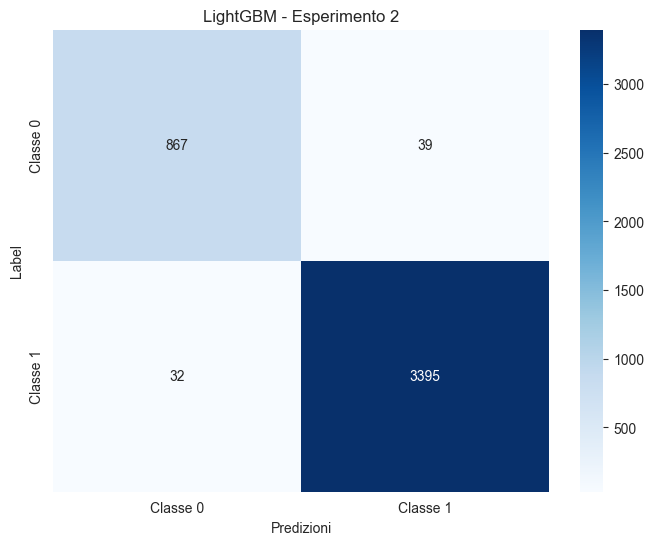

In [29]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp1_lightgbm = lightgbm_model_exp1.predict(X_val_imputed_array_exp1)

# Se il modello restituisce probabilità, ottieni le etichette predette
y_pred_exp1_lightgbm = (y_pred_exp1_lightgbm > 0.5).astype(int)  # Usa la soglia di 0.5 per la classificazione binaria

# 2. Calcola la matrice di confusione
cm_exp1_lightgbm = confusion_matrix(y_val_encoded_exp1, y_pred_exp1_lightgbm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp1_lightgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('LightGBM - Esperimento 2')
plt.show()

# ESPERIMENTO 3

Esperimento effettuato prendendo come riferimento features numeriche da "A Survey on Audio Feature Extraction for Automatic Music Genre Classification" di Dhamodaran et al.

In [30]:
#SPLIT
X_train_imputed_exp2, X_val_imputed_exp2, X_test_imputed_exp2, y_train_encoded_filtered_exp2, y_val_encoded_exp2, y_test_encoded_exp2, subclasses_train, class_encoder_exp2 = split_dataset(
    'exp2_audio_features.csv')

Distribuzione delle classi nel set di addestramento:
Class
Target        34635
Non-Target     5791
Name: count, dtype: int64
Distribuzione delle subclassi nel set di addestramento:
Subclass
Tanker                                     9181
Passengership                              8847
Tug                                        8539
Cargo                                      7705
Sperm Whale                                1087
Humpback Whale                             1063
Fin, Finback Whale                          496
Vessel                                      282
Pygmy Blue Whale                            243
Soundscape                                  185
Fraser_s Dolphin                            171
Long-Finned Pilot Whale                     159
Rain                                        121
Spinner Dolphin                             119
Grampus, Risso_s Dolphin                    116
Killer Whale                                114
Short-Finned (Pacific) Pilot Whale        

In [31]:
#SMOTE
X_train_resampled_exp2, y_train_resampled_exp2 = apply_smote(X_train_imputed_exp2, y_train_encoded_filtered_exp2, subclasses_train)

pd.set_option('display.max_rows', None)  # Rimuove la limitazione del numero massimo di righe visualizzate
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne

SMOTE tra le subclass di Target:
Distribuzione subclassi di Target dopo SMOTE:
Subclass
Acoustic Harassment Devices         9181
Acoustic release                    9181
Cargo                               9181
Echosounder                         9181
Explosion                           9181
Fishing pinger                      9181
Passengership                       9181
Scuba divers                        9181
Seafloor fossil fuel processing     9181
Seal bomb                           9181
Seismic airguns surveys             9181
Sonar                               9181
Tanker                              9181
Tug                                 9181
Underwater Communication Signals    9181
Vessel                              9181
Name: count, dtype: int64
SMOTE tra le subclass di Non-Target:
Distribuzione subclassi di Non-Target dopo SMOTE:
Subclass
Ambient Noise                              1087
Manatee                                    1087
Right whale                           

In [32]:
# Converti i dati in DataFrame
X_train_df_exp2 = pd.DataFrame(X_train_resampled_exp2)
X_val_df_exp2 = pd.DataFrame(X_val_imputed_exp2)
X_test_df_exp2 = pd.DataFrame(X_test_imputed_exp2)
# Aggiungi le etichette per il target
X_train_df_exp2['Class'] = y_train_resampled_exp2
X_val_df_exp2['Class'] = y_val_encoded_exp2
X_test_df_exp2['Class'] = y_test_encoded_exp2

In [33]:
y_train_resampled_df_exp2 = pd.DataFrame(y_train_resampled_exp2, columns=['Class'])
print("Distribuzione delle classi nel set di training dopo SMOTE:")
display(y_train_resampled_df_exp2['Class'].value_counts())

Distribuzione delle classi nel set di training dopo SMOTE:


Class
1.0    146896
0.0    146896
Name: count, dtype: int64

In [34]:
# Converte i DataFrame in ndarray
X_train_resampled_array_exp2 = X_train_resampled_exp2  # Supponendo che sia già un ndarray
X_val_imputed_array_exp2 = X_val_imputed_exp2.values  # Converti il DataFrame in ndarray
X_test_imputed_array_exp2 = X_test_imputed_exp2.values  # Converti il DataFrame in ndarray

In [35]:
#TRAIN
random_forest_model_exp2 = oversampling_binary.train_random_forest(
    X_train_resampled_array_exp2, 
    y_train_resampled_exp2,
    X_val_imputed_array_exp2,
    y_val_encoded_exp2,
    X_test_imputed_array_exp2,
    y_test_encoded_exp2
);


Inizio dell'addestramento del modello Random Forest...


Addestramento Random Forest: 100%|██████████| 100/100 [03:19<00:00,  1.99s/albero]

Performance sul set di validazione:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       906
           1       1.00      0.99      0.99      3427

    accuracy                           0.99      4333
   macro avg       0.98      0.99      0.98      4333
weighted avg       0.99      0.99      0.99      4333

Accuratezza sul set di validazione: 0.9898453727209785
Performance sul set di test:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1115
           1       0.98      0.99      0.98      5119

    accuracy                           0.97      6234
   macro avg       0.97      0.94      0.96      6234
weighted avg       0.97      0.97      0.97      6234

Accuratezza sul set di test: 0.9748155277510426


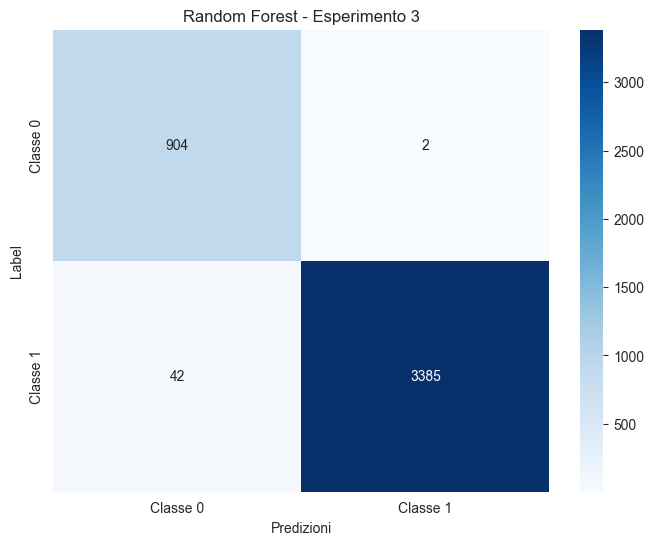

In [36]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp2 = random_forest_model_exp2.predict(X_val_imputed_array_exp2)

# 2. Calcola la matrice di confusione
cm_exp2 = confusion_matrix(y_val_encoded_exp2, y_pred_exp2)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp2, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('Random Forest - Esperimento 3')
plt.show()

In [37]:
svm_model_exp2 = oversampling_binary.train_svm(X_train_resampled_array_exp2, y_train_resampled_exp2, X_val_imputed_array_exp2, y_val_encoded_exp2, X_test_imputed_array_exp2, y_test_encoded_exp2)

Inizio addestramento del modello...
Tempo di addestramento: 1.475618600845337
Inizio previsione sul set di validazione...
Tempo di previsione sul set di validazione: 0.0020008087158203125
Performance del set di validazione:
Accuracy: 0.879298407569813
              precision    recall  f1-score   support

  Non-Target     0.7333    0.6645    0.6972       906
      Target     0.9134    0.9361    0.9246      3427

    accuracy                         0.8793      4333
   macro avg     0.8233    0.8003    0.8109      4333
weighted avg     0.8758    0.8793    0.8771      4333

Inizio previsione sul set di test...
Tempo di previsione sul set di test: 0.0010013580322265625
Performance del set di test:
Accuracy: 0.8591594481873597
              precision    recall  f1-score   support

  Non-Target     0.6196    0.5507    0.5831      1115
      Target     0.9044    0.9264    0.9153      5119

    accuracy                         0.8592      6234
   macro avg     0.7620    0.7385    0.7492      

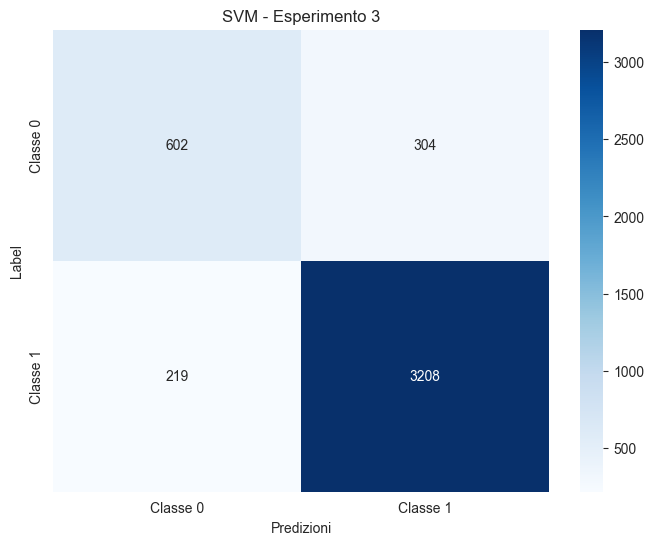

In [38]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp2_svm = svm_model_exp2.predict(X_val_imputed_array_exp2)

# 2. Calcola la matrice di confusione
cm_exp2_svm = confusion_matrix(y_val_encoded_exp2, y_pred_exp2_svm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp2_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('SVM - Esperimento 3')
plt.show()

In [39]:
y_train_resampled_exp2 = y_train_resampled_exp2.astype(int)
y_val_encoded_exp2 = y_val_encoded_exp2.astype(int)
y_test_encoded_exp2 = y_test_encoded_exp2.astype(int)

In [40]:
lightgbm_model_exp2 = oversampling_binary.train_lightgbm(X_train_resampled_array_exp2, y_train_resampled_exp2, X_val_imputed_array_exp2, y_val_encoded_exp2, X_test_imputed_array_exp2, y_test_encoded_exp2)

Training Progress:  20%|██        | 2/10 [00:00<00:01,  7.97it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 29379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8469
[LightGBM] [Info] Number of data points in the train set: 29379, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

Training Progress:  30%|███       | 3/10 [00:00<00:01,  6.05it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 88137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 88137, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

Training Progress:  40%|████      | 4/10 [00:00<00:01,  4.64it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 117516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 117516, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

Training Progress:  50%|█████     | 5/10 [00:01<00:01,  3.75it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 146895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 146895, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

Training Progress:  60%|██████    | 6/10 [00:02<00:02,  1.51it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 58757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 205653, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714291 -> initscore=0.916315
[LightGBM] [Info] Start training from score 0.916315


Training Progress:  70%|███████   | 7/10 [00:04<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 146896, number of negative: 88136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 235032, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625004 -> initscore=0.510844
[LightGBM] [Info] Start training from score 0.510844


Training Progress:  80%|████████  | 8/10 [00:06<00:02,  1.31s/it]

[LightGBM] [Info] Number of positive: 146896, number of negative: 117515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 264411, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555559 -> initscore=0.223159
[LightGBM] [Info] Start training from score 0.223159


Training Progress:  90%|█████████ | 9/10 [00:08<00:01,  1.67s/it]

[LightGBM] [Info] Number of positive: 146896, number of negative: 146894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 293790, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000014
[LightGBM] [Info] Start training from score 0.000014


Training Progress: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Distribuzione delle classi reali (validazione): [ 906 3427]
Distribuzione delle classi predette (validazione): [ 935 3398]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       906
           1       1.00      0.99      0.99      3427

    accuracy                           0.99      4333
   macro avg       0.98      0.99      0.99      4333
weighted avg       0.99      0.99      0.99      4333

Accuratezza sul set di validazione: 0.9915
Distribuzione delle classi reali (test): [1115 5119]
Distribuzione delle classi predette (test): [1058 5176]
Report di classificazione del set di test:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1115
           1       0.98      0.99      0.99      5119

    accuracy                           0.98      6234
   macro avg       0.98      0.96      0.97      6234
weighted avg       0.98      0.98

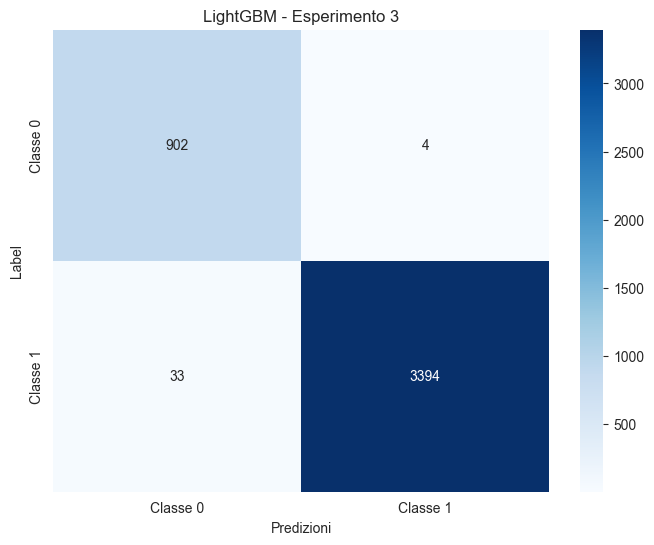

In [41]:
# 1. Effettua le predizioni sul set di convalida
y_pred_exp2_lightgbm = lightgbm_model_exp2.predict(X_val_imputed_array_exp2)

# Se il modello restituisce probabilità, ottieni le etichette predette
y_pred_exp2_lightgbm = (y_pred_exp2_lightgbm > 0.5).astype(int)  # Usa la soglia di 0.5 per la classificazione binaria

# 2. Calcola la matrice di confusione
cm_exp2_lightgbm = confusion_matrix(y_val_encoded_exp2, y_pred_exp2_lightgbm)

# 3. Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp2_lightgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predizioni')
plt.ylabel('Label')
plt.title('LightGBM - Esperimento 3')
plt.show()